**GPS Elevation Charter**


This reads in a GPX file and creates an elevation chart of the tracks held within.


Starting with pulling in some necessary modules...

In [1]:
using LinearAlgebra;
using Plots;
using EzXML;
using Dates;

Structures are then defined to represent GPS points and tracks, along with structures representing how these will be displayed on the graph in the end.

In [2]:
""" Describes a GPS point pulled from GPX """
struct GpsPoint
    lat::AbstractFloat
    lon::AbstractFloat
    el::AbstractFloat
    time::DateTime
end

""" Describes a full GPS Track pulled from GPX """
struct GpsTrack
    name::String
    points::Array{GpsPoint}
end

""" Describes a point along a plotted track by x=distance, y=elevation """
struct PlotPoint
    dist::AbstractFloat
    el::AbstractFloat
end

""" Describes a graph, with its statistics, for a GPS track """
struct PlotGraph
    name::String
    high::AbstractFloat
    low::AbstractFloat
    gain::AbstractFloat
    loss::AbstractFloat
    dist::AbstractFloat
    points::Array{PlotPoint}
end

PlotGraph

**GPX Reading**

The following code is good for reading GPX files. The primary use of this is the `read_gpx` method, which will read a GPX file, given by filename, and output an array of GpsTracks representing each track in the file.

In [3]:
""" Pull the tracks out of a GPX node """
tracks(gpx::EzXML.Node) = [track for track in eachelement(gpx) if iselement(track) && nodename(track) == "trk"]

""" Pull the track name out of a GPX node """
track_name(track::EzXML.Node) = nodecontent(first([el for el in eachelement(track) if iselement(el) && nodename(el) == "name"]))

""" Pull all segments out of one GPX track """
track_segs(track::EzXML.Node) = [seg for seg in eachelement(track) if iselement(seg) && nodename(seg) == "trkseg"]
""" Pull every point out of the GPX for one track segment """
seg_points(seg::EzXML.Node) = [point for point in eachelement(seg) if iselement(point) && nodename(point) == "trkpt"]

""" Pull a GpsPoint out of a GPX XML representation of it """
function gps_from_xml(point::EzXML.Node)
    lat = parse(Float64, point["lat"])
    lon = parse(Float64, point["lon"])
    els = [el for el in eachelement(point) if iselement(el) && nodename(el) == "ele"]
    el = length(els) > 0 ? parse(Float64, nodecontent(els[1])) : 0
    els = [el for el in eachelement(point) if iselement(el) && nodename(el) == "time"]
    time = length(els) > 0 ? DateTime(nodecontent(els[1]), dateformat"yyyy-mm-ddTHH:MM:SSZ") : DateTime(1,1,1,1,1,1)
    GpsPoint(lat, lon, el, time)
end

""" Read a GPX file, summarizing it into an array of GpsTracks """
function read_gpx(filename::String)
    doc = readxml(filename)
    gpx = root(doc)
    if nodename(gpx) != "gpx"
        throw(DomainError("Invalid GPX File approached"))
    else
        build_tracks = []
    
        for track in tracks(gpx)
            name = track_name(track)
    
            points = sort([gps_from_xml(point) for point in vcat([seg_points(seg) for seg in track_segs(track)]...)], by=x->x.time)
    
            build_track = GpsTrack(name, points)
    
            append!(build_tracks, [build_track])
        end
    
        return build_tracks
    end
end;

**Graph building**


Next, functions to convert GPS tracks into their representation on an elevation graph. The primary interest point here is `gpx_to_plot`, which does the conversion for one GpsTrack.

In [4]:
""" Get a 3D Cartesian vector representation of a GpsPoint
    This assumes a spherical earth, so it is technically not totally right... """
function vector(point::GpsPoint)
    el = point.el + 6371000.0
    lat = 90 - point.lat
    lon = point.lon

    ((el * cosd(lon) * sind(lat)),
     (el * sind(lon) * sind(lat)),
     (el * cosd(lat)))
end

""" Converting a 3D Tuple to a verticle matrix enables matrix math """
tuple_to_matrix(tuple::Tuple{AbstractFloat,AbstractFloat,AbstractFloat}) = [tuple[1]; tuple[2]; tuple[3]]

""" Calculate the distance between two 3D vectors, held in tuples """
distance(v1::Tuple{AbstractFloat,AbstractFloat,AbstractFloat}, v2::Tuple{AbstractFloat,AbstractFloat,AbstractFloat}) =
    sqrt(sum((v1 .- v2) .^ 2)) / 1000.0

""" Convert metric to feet, with a failsafe to just return meters """
m_to_ft(m::AbstractFloat, doIt::Bool = true) = doIt ? 3.28084 * m : m
""" Convert kilometers to miles, with a failsafe to just return kilometers """
km_to_m(km::AbstractFloat, doIt::Bool = true) = doIt ? 0.621371 * km : km

""" Loop through all points in a GpsTrack and convert them to representations on an elevation chart """
function gpx_to_plot(gpx::GpsTrack, imperial::Bool = true)
    if length(gpx.points) < 2
        throw(ArgumentError("GPX track to convert must contain at least 2 points"))
    end

    high = m_to_ft(gpx.points[1].el, imperial)
    low = m_to_ft(gpx.points[1].el, imperial)
    gain = 0
    loss = 0
    dist = 0
    points = [PlotPoint(0, m_to_ft(gpx.points[1].el, imperial))]

    for pindex in 2:length(gpx.points)
        prev = gpx.points[pindex-1]
        point = gpx.points[pindex]
        dist += km_to_m(distance(vector(prev), vector(point)), imperial)

        elchange = point.el - prev.el
        if elchange > 1
            gain += elchange
        else
            loss -= elchange
        end

        el = m_to_ft(point.el, imperial)
        el > high && (high = el)
        el < low && (low = el)

        append!(points, [PlotPoint(dist, el)])
    end

    PlotGraph(gpx.name, high, low, gain, loss, dist, points)
end;

**Helper methods**

Just some helpful things

In [5]:
""" Merge multiple GPS-track-based elevation charts into one for nice display """
function merge_tracks(to_plot::Vector{PlotGraph})
    lastdist = 0
    plot_points = Vector{Tuple{Float64,Float64}}()
    for curr in to_plot
        if length(curr.points) > 0
            points = [(lastdist + point.dist, point.el) for point in curr.points]
            append!(plot_points, points)
            lastdist += curr.dist
        end
    end

    plot_points
end;

**Build the graph!**


This is where the magic all happens and the graph is built.

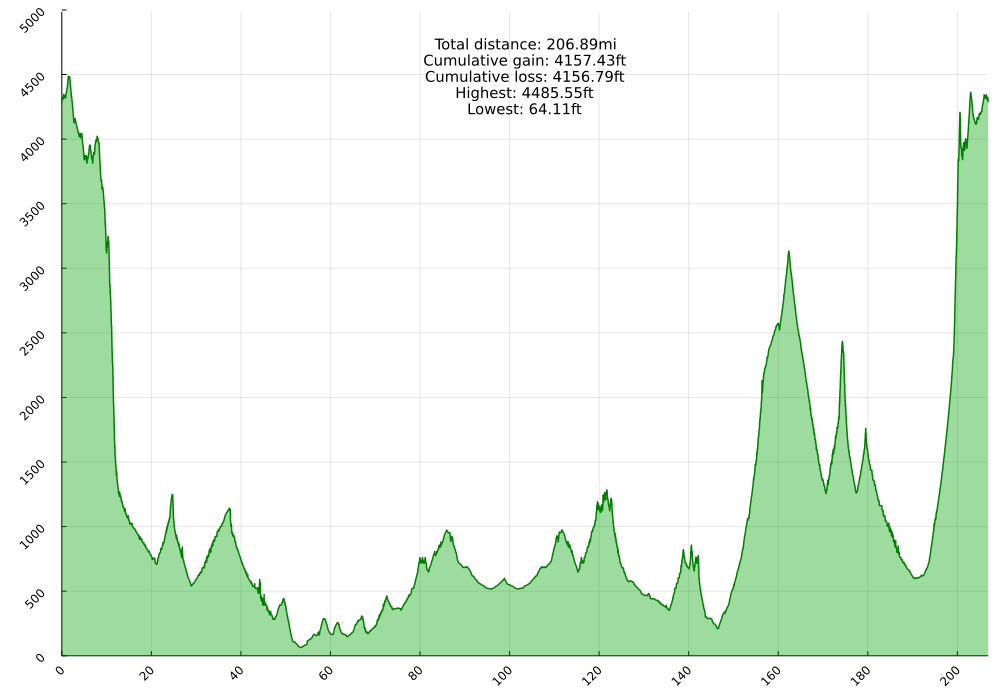

In [6]:
#Start with defining the location of the GPX file to load
#filename = "Anza Borrego Badlands Route 01-27-2020.gpx"
#filepath = "/home/derek/Documents/HIke GPX Files/"
filename = "All Days w Hitches Sep2 ADJ.gpx"
filepath = "/home/derek/Pictures/Car Living/2020/01 January/24 ABBR/"

#read the GPX file, convert the tracks to elevation chart representation, and merge them into one chart form
gpx = read_gpx(filepath*filename);
to_plot = [gpx_to_plot(track) for track in gpx];
plot_points = merge_tracks(to_plot)

# Calculate some points on the graph to decide the size of the graph, etc.
dist = round(sum([track.dist for track in to_plot]), digits=2)
max_y = maximum([track.high for track in to_plot])
min_y = minimum([track.low for track in to_plot])
if min_y > 0; min_y = 0; end
cum_gain = round(sum([track.gain for track in to_plot]), digits=2)
cum_loss = round(sum([track.loss for track in to_plot]), digits=2)
high = round(maximum([track.high for track in to_plot]), digits=2)
low = round(minimum([track.low for track in to_plot]), digits=2)

#plot it!
plot(plot_points, w=1.5, fill=0, legend=false, color=:green, fillcolor=RGBA(0.05, 0.65, 0.05, 0.40),
        yrange = (min_y,max_y + 500),
        size = (1000,700),
        gridlinewidth=1, tick=20, rot=45, xlim=(0,dist))
annotate!(dist/2, max_y,
            text("Total distance: "*string(dist)*"mi\n"*
                 "Cumulative gain: "*string(cum_gain)*"ft\n"*
                 "Cumulative loss: "*string(cum_loss)*"ft\n"*
                 "Highest: "*string(high)*"ft\n"*
                 "Lowest: "*string(low)*"ft", :center, 10))